# Difference in Differences: A/B Test using Bayesian Statistics

In [39]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from patsy import dmatrices
import statsmodels.api as sm

import pymc as pm
import arviz as az
import numpy
import pymc
import pandas as pd

# Website data for control & variant of the site

Suppose we perform an A/B test on a group of users.  A control period (before the variant was introduced) is compared with the test period (with the variant).  However, in some businesses that might experience a natural increase or decrease in "conversion" in a specific period due to the nature of their business.

Imagine a backpack manufacturer that is performing a variant of their website to help convert more site visitors to buy their backpacks.  Due to their nature of their business, they normally see more purchases in the month before students return to school for their start of another academic year.  How will such a manufacturer measure their campaign effectivenss say in August?  I can perform a Difference-in-Differences (__Diff-in-Diff__) test.

The concept is simple.  In the natural state of being, I see a "lift" from period A to B for everyone (i.e. back-to-school time).  In the same periods for the treatment group of users, I might see an extra "lift" from period A to B. I __subtract__ the difference for treatment group of users from the "natural state of being" users (i.e. everyone else) thus the name [Difference in Differences](https://en.wikipedia.org/wiki/Difference_in_differences) methodology.

Note, the following terminology:

- __control period__ : the time period before the variant was introduced
- __test period__: the time period when the variant was introduced

- __control users__ : users that will not experience the variant in both control and test periods.
- __treatment users__: users that will experience the variant during the test period.


The hypothesis is:

&emsp; $H_{0}$: With the variant, there is no change in Diff-in-Diff

&emsp; $H_{1}$: With the variant, we see a change by x% in Diff-in-Diff

[<img src="../image/Difference_in_Differences.png" width="300"/>](../image/Difference_in_Differences.png)

The above figure shows how the treatment users went from P1 (before the variant at Time 1) to P2 (after the variant at Time 2) while everyone else went from S1 (Time 1) to S2 (Time 2).  One might argue that without the variant, the treatment users should have ended up at point Q but instead P2 measurement is observed.  The difference between P2 and Q is the Diff-in-Diff measurement.

I use the term conversion rate in a broad sense which is behavior that is binary (i.e. buy or not buy, clicked or not clicked, filled out a lead form or not, watched a movie trailer or not, etc.).  With this in mind, there will be 4 datasets needed to perform Diff-in-Diff Bayesian statistics.

# Content

1. [Read Data](#read_data)
2. [Frequentist Test](#frequentist_test)
3. [Diff-in-Diff: Beta Prior](#test_2)
4. [Diff-in-Diff: InverseGamma Prior](#test_3)
5. [Diff-in-Diff: Linear Regression](#test_4)
5. [Conclusion](#conclusion)

## 1. Read data
<a id="read_data"></a>

This is simulated data to illustrate on how to use Bayesian Statistics to perform a Diff-in-Diff test.

In [2]:
df_treat_user_ctrl_period = pd.read_csv('../data/binary_sample_1.csv')
treat_user_ctrl_period    = df_treat_user_ctrl_period['converted'].to_numpy()
treat_user_ctrl_period[0:5]

array([0, 0, 0, 0, 1])

In [3]:
df_treat_user_test_period = pd.read_csv('../data/binary_sample_2.csv')
treat_user_test_period    = df_treat_user_test_period['converted'].to_numpy()
treat_user_test_period[0:5]

array([0, 0, 1, 0, 0])

In [4]:
df_ctrl_user_ctrl_period = pd.read_csv('../data/binary_sample_3.csv')
ctrl_user_ctrl_period    = df_ctrl_user_ctrl_period['converted'].to_numpy()
ctrl_user_ctrl_period[0:5]

array([0, 0, 0, 0, 0])

In [5]:
df_ctrl_user_test_period = pd.read_csv('../data/binary_sample_4.csv')
ctrl_user_test_period    = df_ctrl_user_test_period['converted'].to_numpy()
ctrl_user_test_period[0:5]

array([0, 0, 0, 0, 0])

In [6]:
# Common Sense Check
print("Common Sense Check")
print("Control Users:")
print("   Control Period:  mean = %10.6f  std dev = %10.6f" % (ctrl_user_ctrl_period.mean(), ctrl_user_ctrl_period.std()))
print("   Test Period   :  mean = %10.6f  std dev = %10.6f" % (ctrl_user_test_period.mean(), ctrl_user_test_period.std()))
print("Treatment Users:")
print("   Control Period:  mean = %10.6f  std dev = %10.6f" % (treat_user_ctrl_period.mean(), treat_user_ctrl_period.std()))
print("   Test Period   :  mean = %10.6f  std dev = %10.6f" % (treat_user_test_period.mean(), treat_user_test_period.std()))

Common Sense Check
Control Users:
   Control Period:  mean =   0.123932  std dev =   0.329504
   Test Period   :  mean =   0.138889  std dev =   0.345831
Treatment Users:
   Control Period:  mean =   0.109170  std dev =   0.311853
   Test Period   :  mean =   0.162630  std dev =   0.369028


In [7]:
def plot_posterior_side_by_side(conv_a, conv_b, graph_title):
    plt.figure(figsize=(10, 6))

    # plt.subplot(1, 2, 1)
    plt.hist(conv_a, bins=35, histtype='stepfilled', 
    color='#da6d75', label='Conversion : Control',alpha=0.5)
    plt.legend()

    plt.hist(conv_b, bins=35, histtype='stepfilled',
    color='#52c4a8', label='Conversion : Treatment',alpha=0.5)

    plt.title(graph_title)
    plt.legend()

    plt.show()

In [8]:
def t_test_6_ways(data_a, data_b):
    
    # Assume the variance of the 2 datasets are equal: 2-tail test
    print('Difference in means T-Tests')
    print('   Equal Var & Two Sided:', sps.ttest_ind(a=data_a, b=data_b, equal_var=True, alternative="two-sided"))

    #   1-tail test less than
    print('   Equal Var & A < B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=True, alternative="less"))
    
    #   1-tail test greater than
    print('   Equal Var & A > B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=True, alternative="greater"), '\n')
    
    # Assume the variance of the 2 datasets are NOT equal: 2-tail test
    print('   Not-Equal Var & Two Sided:', sps.ttest_ind(a=data_a, b=data_b, equal_var=False, alternative="two-sided"))

    #   1-tail test less than
    print('   Not-Equal Var & A < B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=False, alternative="less"))
    
    #   1-tail test greater than
    print('   Not-Equal Var & A > B    :', sps.ttest_ind(a=data_a, b=data_b, equal_var=False, alternative="greater"))

# Frequentist Tests
<a id="frequentist_test"></a>
Using our standard t-tests to determine if the mean of the revenue lift is different or less than (control < treatment) per our equal variance and two-sided/one-sided tests, we get:

In [9]:
# Control users in both periods
t_test_6_ways(ctrl_user_ctrl_period, ctrl_user_test_period)

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=-0.5132563552112679, pvalue=0.6079758852688883)
   Equal Var & A < B    : Ttest_indResult(statistic=-0.5132563552112679, pvalue=0.3039879426344442)
   Equal Var & A > B    : Ttest_indResult(statistic=-0.5132563552112679, pvalue=0.6960120573655559) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=-0.5172300183296171, pvalue=0.6052174200258286)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=-0.5172300183296171, pvalue=0.3026087100129143)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=-0.5172300183296171, pvalue=0.6973912899870858)


In [10]:
# Treatment users in both periods
t_test_6_ways(treat_user_ctrl_period, treat_user_test_period)

Difference in means T-Tests
   Equal Var & Two Sided: Ttest_indResult(statistic=-1.748497908186263, pvalue=0.08097251021965225)
   Equal Var & A < B    : Ttest_indResult(statistic=-1.748497908186263, pvalue=0.040486255109826126)
   Equal Var & A > B    : Ttest_indResult(statistic=-1.748497908186263, pvalue=0.9595137448901739) 

   Not-Equal Var & Two Sided: Ttest_indResult(statistic=-1.7825796727653367, pvalue=0.07524508753202636)
   Not-Equal Var & A < B    : Ttest_indResult(statistic=-1.7825796727653367, pvalue=0.03762254376601318)
   Not-Equal Var & A > B    : Ttest_indResult(statistic=-1.7825796727653367, pvalue=0.9623774562339868)


## Conversion Table

Looking at the conversion table for the four groups of observations, we see there is a lift in treatment users over control users using the same comparison periods broadly speaking.  If the sample size is small, we might get this lift by chance.  But, we can get a credible interval for the lift for the treatment in the control period using Bayesian method first then let's repeat the process using Linear Regression. 

| | Control Period | Test Period | Difference |
| --------------- | ------------ | ----------- | ---------- |
| Control Users | 12.4% | 13.9%| 1.5% |
| Treatment Users | 10.9% | 16.3% | 5.4 %|
| Diff in Differences | | | 3.9% | 



## Build a model

Distribution Explorer https://distribution-explorer.github.io

## 2: Diff-in-Diff: Beta Prior
<a id="test_2"></a>

In [11]:
with pm.Model() as did_model:

    # parameter we want to infer with PRIOR
    rate_prior_A  = pm.Beta("ctrl_user_rate_A",  1, 10) # control   user ctrl period
    rate_prior_B  = pm.Beta("ctrl_user_rate_B",  1, 10) # control   user test period
    rate_prior_C  = pm.Beta("treat_user_rate_C", 1, 10) # treatment user ctrl period
    rate_prior_D  = pm.Beta("treat_user_rate_D", 1, 10) # treatment user test period
    
    # likelihood of observing data given parameter
    how_likely_A = pm.Bernoulli("likelihood_A", p=rate_prior_A, observed=ctrl_user_ctrl_period)
    how_likely_B = pm.Bernoulli("likelihood_B", p=rate_prior_B, observed=ctrl_user_test_period)
    how_likely_C = pm.Bernoulli("likelihood_C", p=rate_prior_C, observed=treat_user_ctrl_period)
    how_likely_D = pm.Bernoulli("likelihood_D", p=rate_prior_D, observed=treat_user_test_period)
    
    # POSTERIORS
    conv_a = pm.Deterministic('conversion_A', rate_prior_A)
    conv_b = pm.Deterministic('conversion_B', rate_prior_B)
    conv_c = pm.Deterministic('conversion_C', rate_prior_C)
    conv_d = pm.Deterministic('conversion_D', rate_prior_D)
    
    # Calculate lift difference
    pm.Deterministic('conv_lift_ctrl_users',  conv_a - conv_b) 
    pm.Deterministic('conv_lift_treat_users', conv_c - conv_d) 
    
    # Difference in Differences
    # DiD = (conv_a - conv_b) - (conv_c - conv_d)
    pm.Deterministic('conv_lift_diff_in_diff', (conv_a - conv_b) - (conv_c - conv_d))
    
    # Hit the magical inference button
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ctrl_user_rate_A, ctrl_user_rate_B, treat_user_rate_C, treat_user_rate_D]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


In [12]:
# Posterior Predictive Values
post_conversion_a1 = trace.posterior.stack(draws=("chain", "draw"))["conversion_A"].values 
post_conversion_b1 = trace.posterior.stack(draws=("chain", "draw"))["conversion_B"].values
post_conversion_c1 = trace.posterior.stack(draws=("chain", "draw"))["conversion_C"].values 
post_conversion_d1 = trace.posterior.stack(draws=("chain", "draw"))["conversion_D"].values

print("Control users:   ", post_conversion_a1[0:5], post_conversion_b1[0:5])
print("Treatment users: ", post_conversion_c1[0:5], post_conversion_d1[0:5])

# Relative Lift
conversion_lift_ctrl_users1 = trace.posterior.stack(draws=("chain", "draw"))["conv_lift_ctrl_users"].values
conversion_lift_treat_users1 = trace.posterior.stack(draws=("chain", "draw"))["conv_lift_treat_users"].values
diff_in_diff1 = trace.posterior.stack(draws=("chain", "draw"))["conv_lift_diff_in_diff"].values

print("\n")
print("Control users lift      : ", conversion_lift_ctrl_users1[0:5])
print("Treatment users lift    : ", conversion_lift_treat_users1[0:5])
print("Diff in Differences lift: ", diff_in_diff1[0:5])

Control users:    [0.09251703 0.09486843 0.15406295 0.15743737 0.11136572] [0.12100761 0.11598382 0.15473035 0.17451848 0.11549823]
Treatment users:  [0.08706639 0.12878599 0.1158496  0.11310881 0.10009781] [0.13063315 0.13584606 0.15199537 0.15164299 0.1703464 ]


Control users lift      :  [-0.02849057 -0.02111539 -0.0006674  -0.01708111 -0.00413251]
Treatment users lift    :  [-0.04356676 -0.00706007 -0.03614577 -0.03853417 -0.07024859]
Diff in Differences lift:  [ 0.01507619 -0.01405533  0.03547837  0.02145306  0.06611608]


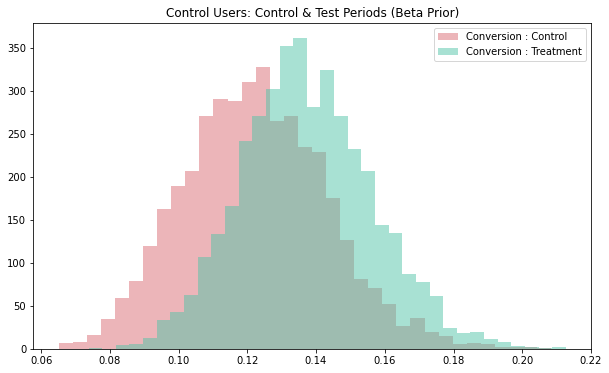

In [13]:
plot_posterior_side_by_side(post_conversion_a1, post_conversion_b1, 
                            'Control Users: Control & Test Periods (Beta Prior)')

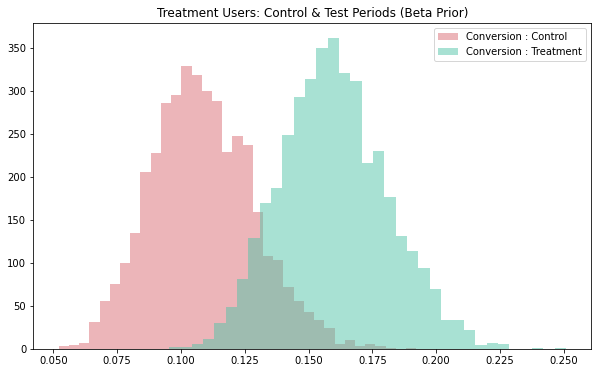

In [14]:
plot_posterior_side_by_side(post_conversion_c1, post_conversion_d1, 
                            'Treatment Users: Control & Test Periods (Beta Prior)')

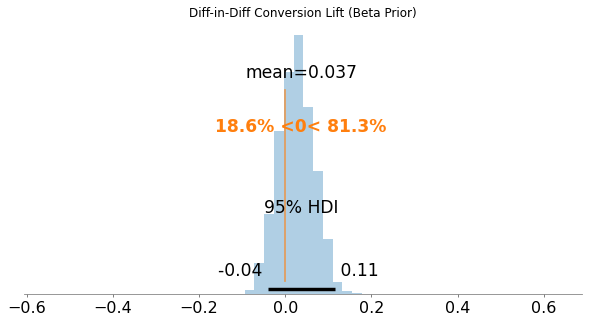

In [15]:
ax = az.plot_posterior(trace, var_names = ['conv_lift_diff_in_diff'], kind='hist', 
                  hdi_prob = 0.95, ref_val=0, textsize = 16, figsize=(10, 5))

ax.set_title('Diff-in-Diff Conversion Lift (Beta Prior)')
plt.show()

In [17]:
print('Controlling for Seasonality (Beta Prior)')
print('   Probability of Conversion Lift (treatment users > control users) = %.6f' % ((diff_in_diff1 > 0).mean()))

Controlling for Seasonality (Beta Prior)
   Probability of Conversion Lift (treatment users > control users) = 0.813500


In [19]:
# Posterior Mean & Variance
print("Posterior Mean & Variance: Control Users")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (post_conversion_a1.mean(), post_conversion_a1.std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (post_conversion_b1.mean(), post_conversion_b1.std()))

print("\nPosterior Mean & Variance: Treatment Users")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (post_conversion_c1.mean(), post_conversion_c1.std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (post_conversion_d1.mean(), post_conversion_d1.std()))

Posterior Mean & Variance: Control Users
   Control (A):  mean =   0.122441  std dev =   0.020890
   Test    (B):  mean =   0.137361  std dev =   0.019081

Posterior Mean & Variance: Treatment Users
   Control (A):  mean =   0.108466  std dev =   0.019982
   Test    (B):  mean =   0.160031  std dev =   0.020842


## 3. Diff-in-Diff : InverseGamma Prior
<a id="test_3"></a>

Let's try a different prior to see if we get similar results.

In [20]:
with pm.Model() as did_model2:

    # parameter we want to infer with PRIOR
    rate_prior_A  = pm.InverseGamma("ctrl_user_rate_A",  alpha=3.0, beta=1.0) # control   user ctrl period
    rate_prior_B  = pm.InverseGamma("ctrl_user_rate_B",  alpha=3.0, beta=1.0) # control   user test period
    rate_prior_C  = pm.InverseGamma("treat_user_rate_C", alpha=3.0, beta=1.0) # treatment user ctrl period
    rate_prior_D  = pm.InverseGamma("treat_user_rate_D", alpha=3.0, beta=1.0) # treatment user test period
    # rate_prior_A  = pm.Beta("ctrl_user_rate_A",  1, 10) # control   user ctrl period
    # rate_prior_B  = pm.Beta("ctrl_user_rate_B",  1, 10) # control   user test period
    # rate_prior_C  = pm.Beta("treat_user_rate_C", 1, 10) # treatment user ctrl period
    # rate_prior_D  = pm.Beta("treat_user_rate_D", 1, 10) # treatment user test period
    
    # likelihood of observing data given parameter
    how_likely_A = pm.Bernoulli("likelihood_A", p=rate_prior_A, observed=ctrl_user_ctrl_period)
    how_likely_B = pm.Bernoulli("likelihood_B", p=rate_prior_B, observed=ctrl_user_test_period)
    how_likely_C = pm.Bernoulli("likelihood_C", p=rate_prior_C, observed=treat_user_ctrl_period)
    how_likely_D = pm.Bernoulli("likelihood_D", p=rate_prior_D, observed=treat_user_test_period)
    
    # POSTERIORS
    conv_a = pm.Deterministic('conversion_A', rate_prior_A)
    conv_b = pm.Deterministic('conversion_B', rate_prior_B)
    conv_c = pm.Deterministic('conversion_C', rate_prior_C)
    conv_d = pm.Deterministic('conversion_D', rate_prior_D)
    
    # Calculate lift difference
    pm.Deterministic('conv_lift_ctrl_users',  conv_a - conv_b) 
    pm.Deterministic('conv_lift_treat_users', conv_c - conv_d) 
    
    # Difference in Differences
    # DiD = (conv_a - conv_b) - (conv_c - conv_d) 
    pm.Deterministic('conv_lift_diff_in_diff', (conv_a - conv_b) - (conv_c - conv_d))
    
    # Hit the magical inference button
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ctrl_user_rate_A, ctrl_user_rate_B, treat_user_rate_C, treat_user_rate_D]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


In [21]:
# Posterior Predictive Values
post_conversion_a2 = trace2.posterior.stack(draws=("chain", "draw"))["conversion_A"].values 
post_conversion_b2 = trace2.posterior.stack(draws=("chain", "draw"))["conversion_B"].values
post_conversion_c2 = trace2.posterior.stack(draws=("chain", "draw"))["conversion_C"].values 
post_conversion_d2 = trace2.posterior.stack(draws=("chain", "draw"))["conversion_D"].values

print("Control users:   ", post_conversion_a2[0:5], post_conversion_b2[0:5])
print("Treatment users: ", post_conversion_c2[0:5], post_conversion_d2[0:5])

# Relative Lift
conversion_lift_ctrl_users2 = trace2.posterior.stack(draws=("chain", "draw"))["conv_lift_ctrl_users"].values
conversion_lift_treat_users2 = trace2.posterior.stack(draws=("chain", "draw"))["conv_lift_treat_users"].values
diff_in_diff2 = trace2.posterior.stack(draws=("chain", "draw"))["conv_lift_diff_in_diff"].values

print("\n")
print("Control users lift      : ", conversion_lift_ctrl_users2[0:5])
print("Treatment users lift    : ", conversion_lift_treat_users2[0:5])
print("Diff in Differences lift: ", diff_in_diff2[0:5])

Control users:    [0.08970777 0.1378386  0.15956659 0.1347647  0.11926093] [0.12778039 0.1979913  0.1271213  0.12648839 0.16048873]
Treatment users:  [0.18308005 0.1019521  0.16677501 0.1242551  0.13663355] [0.17121985 0.16998125 0.16206233 0.12729033 0.16618606]


Control users lift      :  [-0.03807262 -0.0601527   0.03244528  0.00827631 -0.04122779]
Treatment users lift    :  [ 0.01186021 -0.06802915  0.00471268 -0.00303523 -0.02955251]
Diff in Differences lift:  [-0.04993283  0.00787645  0.02773261  0.01131154 -0.01167529]


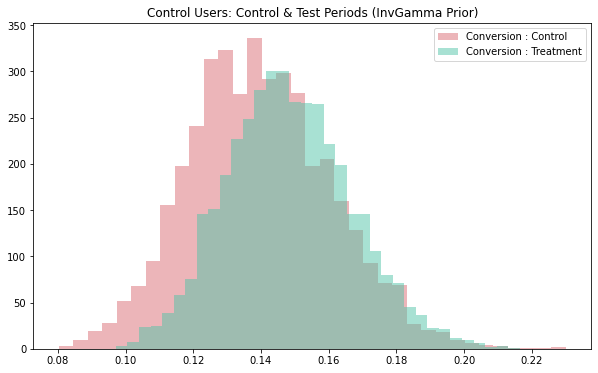

In [22]:
plot_posterior_side_by_side(post_conversion_a2, post_conversion_b2, 
                            'Control Users: Control & Test Periods (InvGamma Prior)')

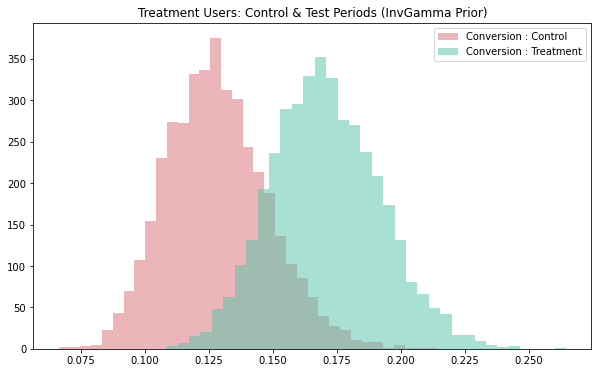

In [23]:
plot_posterior_side_by_side(post_conversion_c2, post_conversion_d2, 
                            'Treatment Users: Control & Test Periods (InvGamma Prior)')

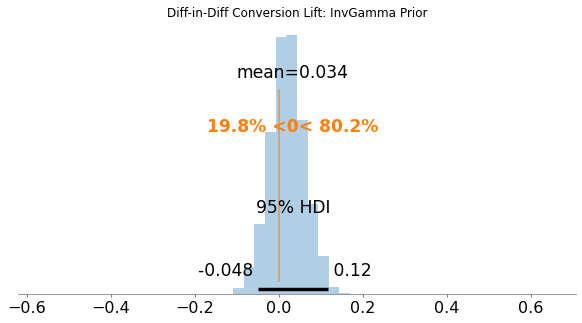

In [24]:
ax = az.plot_posterior(trace2, var_names = ['conv_lift_diff_in_diff'], kind='hist', 
                  hdi_prob = 0.95, ref_val=0, textsize = 16, figsize=(10, 5))

ax.set_title('Diff-in-Diff Conversion Lift: InvGamma Prior')
plt.show()

In [25]:
print('Controlling for Seasonality (Beta Prior)')
print('   Probability of Conversion Lift (treatment users > control users) = %.6f' % ((diff_in_diff2 > 0).mean()))

Controlling for Seasonality (Beta Prior)
   Probability of Conversion Lift (treatment users > control users) = 0.801750


In [26]:
# Posterior Mean & Variance
print("Posterior Mean & Variance: Control Users")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (post_conversion_a1.mean(), post_conversion_a1.std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (post_conversion_b1.mean(), post_conversion_b1.std()))

print("\nPosterior Mean & Variance: Treatment Users")
print("   Control (A):  mean = %10.6f  std dev = %10.6f" % (post_conversion_c1.mean(), post_conversion_c1.std()))
print("   Test    (B):  mean = %10.6f  std dev = %10.6f" % (post_conversion_d1.mean(), post_conversion_d1.std()))

Posterior Mean & Variance: Control Users
   Control (A):  mean =   0.122441  std dev =   0.020890
   Test    (B):  mean =   0.137361  std dev =   0.019081

Posterior Mean & Variance: Treatment Users
   Control (A):  mean =   0.108466  std dev =   0.019982
   Test    (B):  mean =   0.160031  std dev =   0.020842


## Diff-in-Diff Linear Regression
<a id="test_4"></a>
A frequentist approach to measuring the effect of Diff-in-Diff is to run a linear regression against the group of users against the two periods and the interaction term of the treatment users in the test periods.  First, I will encode the following 2 variables:

- is_treat_user: 1 if it is a treatment user, 0 otherwise
- is_test_period: 1 if it is in a test period, 0 otherwise

To read more on Diff-in-Diff, here are some references: 
- https://mixtape.scunning.com/09-difference_in_differences
- https://medium.com/bukalapak-data/difference-in-differences-8c925e691fff
- https://www3.nd.edu/~nmark/Climate/Diff-in-Diff.pdf

In [28]:
# Sample A : Treatment Users in Control Period
df_A = df_treat_user_ctrl_period
df_A['is_treat_user'] = 1
df_A['is_test_period'] = 0

In [29]:
# Sample B: Treatment Users in Test Period
df_B = df_treat_user_test_period
df_B['is_treat_user'] = 1
df_B['is_test_period'] = 1

In [30]:
# Sample C: Control Users in Control Period
df_C = df_ctrl_user_ctrl_period
df_C['is_treat_user'] = 0
df_C['is_test_period'] = 0

In [31]:
# Sample D: Control Users in Test Period
df_D = df_ctrl_user_test_period
df_D['is_treat_user'] = 0
df_D['is_test_period'] = 1

In [32]:
df = pd.concat([df_A, df_B, df_C, df_D])

In [36]:
df[0:5]

,converted,is_treat_user,is_test_period
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,1,1,0


In [40]:
reg_exp = 'converted ~ is_treat_user + is_test_period + is_treat_user * is_test_period'
y_train, X_train = dmatrices(reg_exp, df, return_type='dataframe')

In [41]:
did_model = sm.OLS(endog=y_train, exog=X_train)

In [42]:
did_model_results = did_model.fit()

In [43]:
did_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.155
Date:                Mon, 04 Sep 2023   Prob (F-statistic):              0.326
Time:                        20:20:40   Log-Likelihood:                -371.99
No. Observations:                1076   AIC:                             752.0
Df Residuals:                    1072   BIC:                             771.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.1239      0.022      5.534      0.000       0.080       0.168
is_treat_user                   -0.0148      0.032     -0.464      0.643      -0.077       0.048
is_test_period                   0.0150      0.029      0.509      0.611      -0.043       0.073
is_treat_user:is_test_period     0.0385      0.042      0.912      0.362      -0.044       0.121
==============================================================================
Omnibus:                      413.646   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.584
Skew:                           2.117   Prob(JB):                    1.13e-236
Kurtosis:                       5.511   Cond. No.                         7.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

## Bayesian Statistics vs. Linear Regression
<a id="conclusion"></a>

The __Linear Regression__ method of teasing out the Diff-in-Diff is quite intuitive.  The coefficient of 0.0385 is very close to the means of Diff-in-Diff in the 2 trials using Bayesian method.  However, in the linear regression, I see the p-value (P>|t|) for the interaction term (is_treat_user:is_test_period) is at 0.362 which says there is a 36.2% chance that this term has no affect on the dependent variable.  In interpreting the \[0.025 and 0.975\] says the 95% of the value of this coefficient lies between -0.044 and 0.121.  It is important to note that the zero is within this range.  Last but not least, I should now verify that all the assumptions that are important for linear regression held otherwise the results from the linear regression may not be valid.  

What are the assumptions for linear regressions?  The ususal suspects are:

- Dependent variable has a linear relationship with the explantory variables
- Homoscedasticity (same variance)
- No auto-correlation (observations are independent from each other)
- No or little muticollinearity (one variable is not a multiple of another)
- Multivariate Normality (means of variable should be normally distributed)
    - residuals from regression is normally distributed 
    
Using __Bayesian methods__ of finding the Diff-in-Diff has no such assumptions needed for linear regression.  Looking at the distribution graphs above, I see that the treatment users in test period has an average 3.6-3.7% increased in conversion around 80% of the time.
